<a href="https://colab.research.google.com/github/Deygoms/TimeSeries-GenerationSolar/blob/main/TrabajoF_seriesT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo final - Análisis de series de tiempo**

---
* **Estudiante 1:** -Deyson Gomez Sanchez
* **Estudiante 2:** -Elizabeth Moreno Bohorquez

# Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Datos

In [ ]:
# Frecuencia de muestreo: 1 muestra por hora
dt = 1.0  # Delta tiempo en horas
fs = 1/dt  # Hz (1/hora)
fft_size = 216
sample_rate = 1e6

In [ ]:
df = pd.read_csv('/content/Datosnuevos.csv', sep=';', parse_dates=['Timestamp'],
                 index_col='Timestamp', encoding='latin-1', decimal=',',dayfirst=True)
# Extraer la serie de radiación solar
# pd.to_numeric convierte valores a números, errors='coerce' convierte valores no numéricos a NaN
radiacion = df['Radiacion [Wh/m2]']
potencia = df['Generación [Kwh]']
# Reemplazar NaN con 0 si existen
radiacion = np.nan_to_num(radiacion, nan=0.0)
tiempo=df.index.dayofyear + df.index.hour/24 + df.index.minute/(24*60)
tiempo.unique()
potencia = np.nan_to_num(potencia, nan=0.0)




Total de muestras: 745


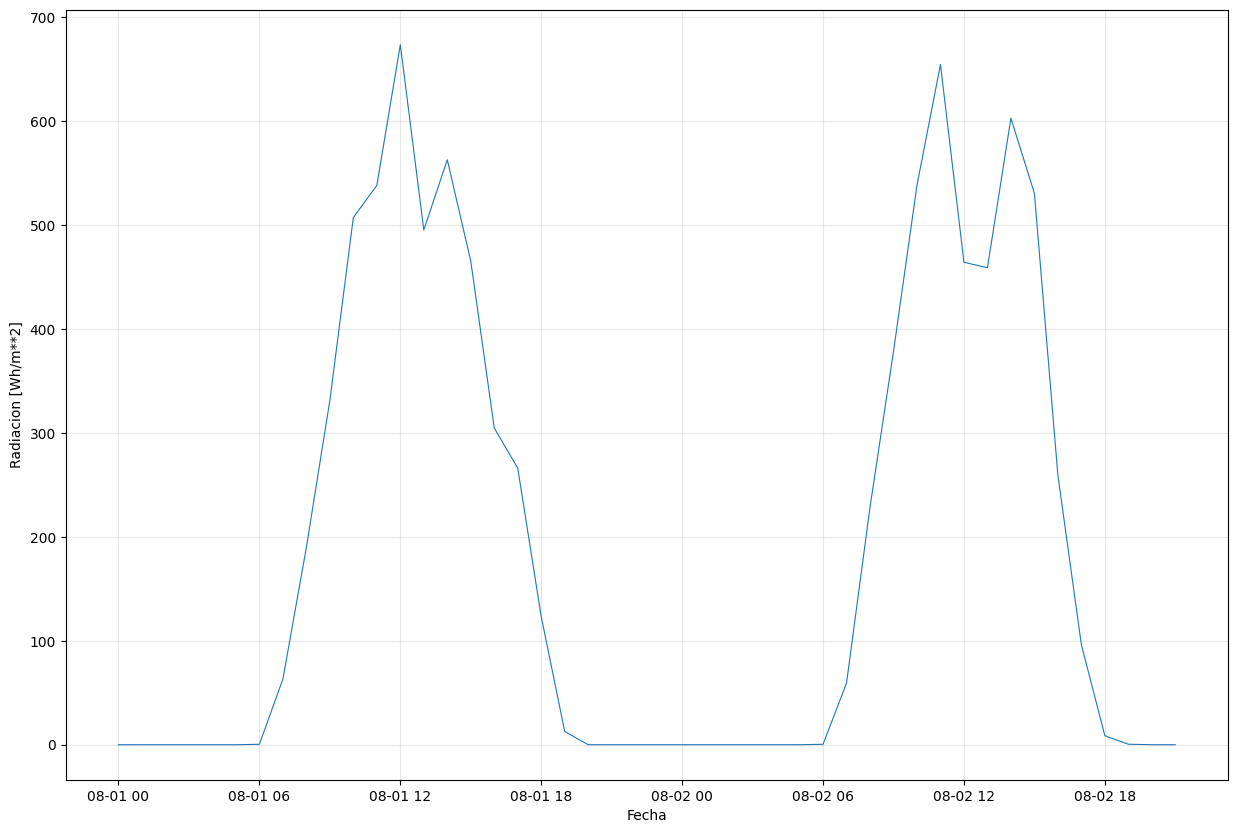

In [ ]:
# Número total de muestras
N = len(radiacion)
print(f"Total de muestras: {N}")

# ===== GRÁFICA 1: SERIE TEMPORAL ORIGINAL =====
plt.figure(figsize=(15, 10))
plt.plot(df.index[0:23*2], radiacion[0:23*2], linewidth=0.8)
plt.xlabel('Fecha')
plt.ylabel('Radiacion [Wh/m**2]')
#plt.title('Serie temporal de radiacion solar')
plt.grid(True, alpha=0.3)


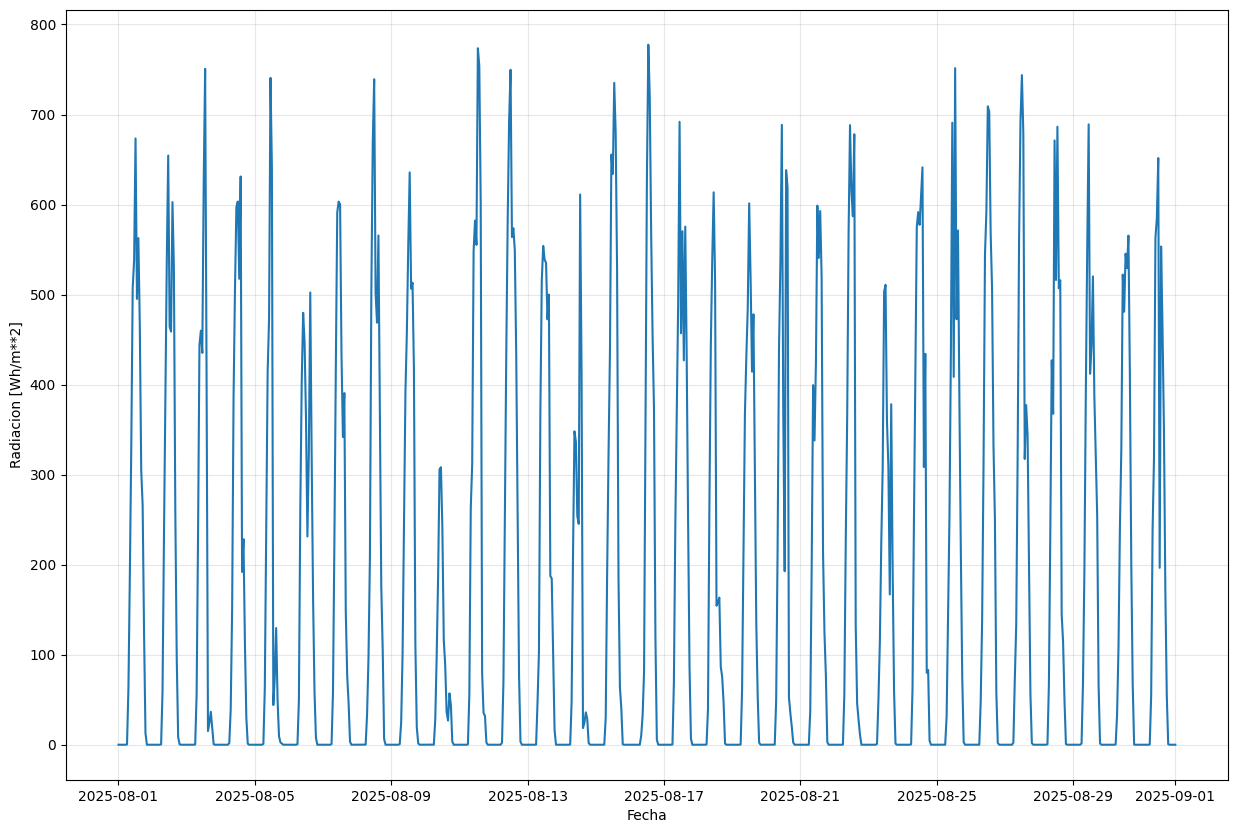

In [ ]:
plt.figure(figsize=(15, 10))

plt.plot(df.index, radiacion)
plt.xlabel('Fecha')
plt.ylabel('Radiacion [Wh/m**2]')
#plt.title('Serie temporal de radiacion solar')
plt.grid(True, alpha=0.3)

# Análisis expliratorio

In [ ]:
print(f"\nEstadísticas de Irradiancia (datos diurnos):")
print(f"  - Media: {radiacion.mean():.2f} Wh/m²")
print(f"  - Mediana: {np.median(radiacion):.2f} Wh/m²")


print(f"  - Desviación estándar: {np.std(radiacion):.2f} Wh/m²")
print(f"  - Percentil 95: {np.percentile(radiacion,95):.2f} Wh/m²")
print(f"  - Percentil 99: {np.percentile(radiacion,99):.2f} Wh/m²")




Estadísticas de Irradiancia (datos diurnos):
  - Media: 166.44 Wh/m²
  - Mediana: 7.70 Wh/m²
  - Desviación estándar: 228.73 Wh/m²
  - Percentil 95: 625.26 Wh/m²
  - Percentil 99: 740.04 Wh/m²


In [ ]:
print(max(radiacion))
print(min(radiacion))

777.525
0.0


# Transformada de fourier

Por defecto python hace:

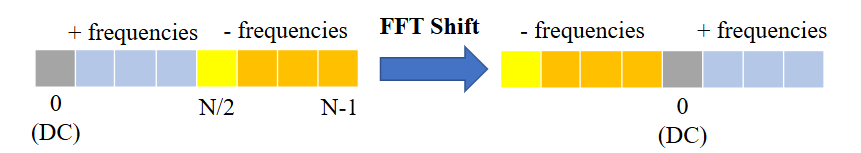

Por lo tanto el siguiente codigo organiza la FFT colocando las frecuencias negaticas a la izquierda


In [ ]:
tfourier = np.fft.fft(radiacion)
tfourier_mag = np.abs(tfourier)
tfourier_phase = np.angle(tfourier)
# np.fft.fftfreq genera el array de frecuencias para N muestras con frecuencia de muestreo fs
freqs = np.fft.fftfreq(N, d=dt)
# Para tomar la parte positiva
tfourier_mag = tfourier_mag[:N//2]
tfourier_phase = tfourier_phase[:N//2]
timegraf=tiempo[:N//2]
freqs=freqs[:N//2]

Text(0, 0.5, 'FFT Magnitud')

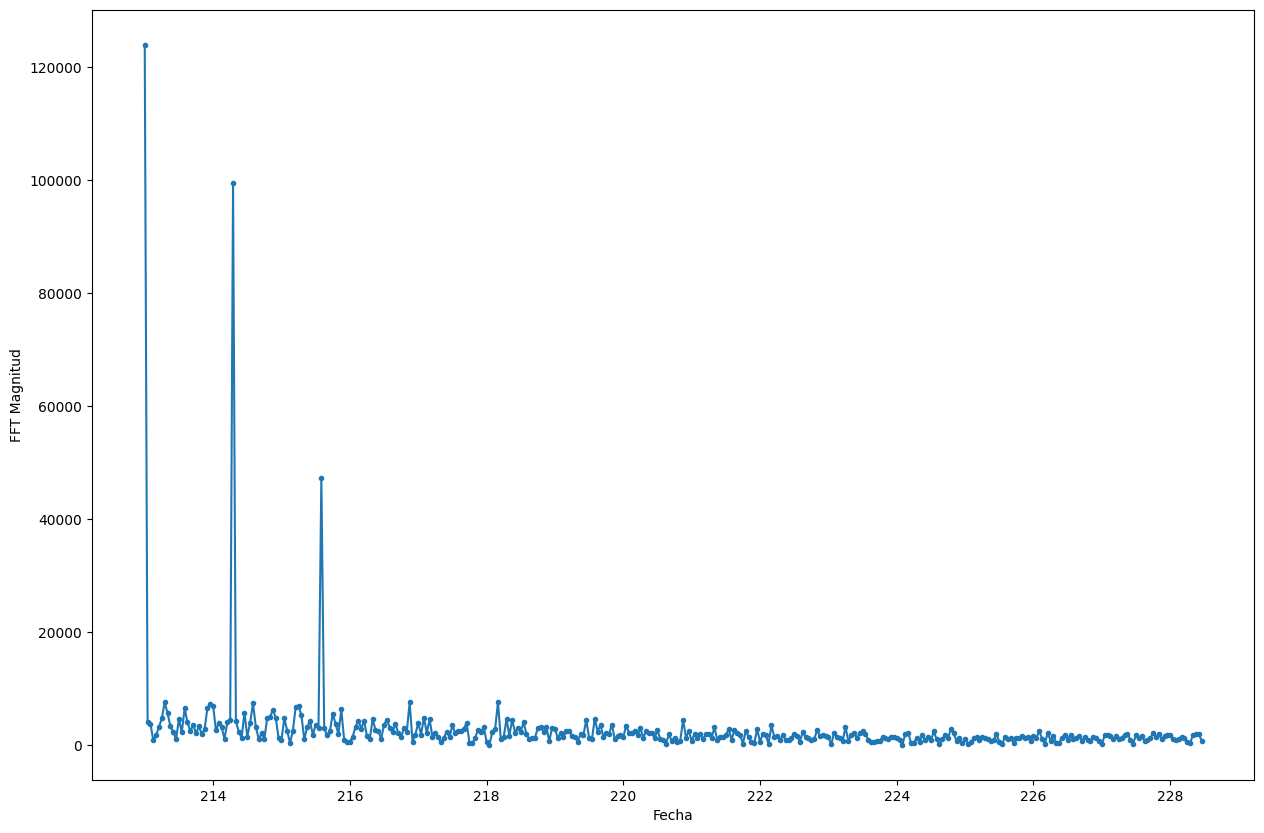

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(timegraf,tfourier_mag,'.-')
plt.xlabel('Fecha')
plt.ylabel('FFT Magnitud')



Text(0, 0.5, 'FFT Fase')

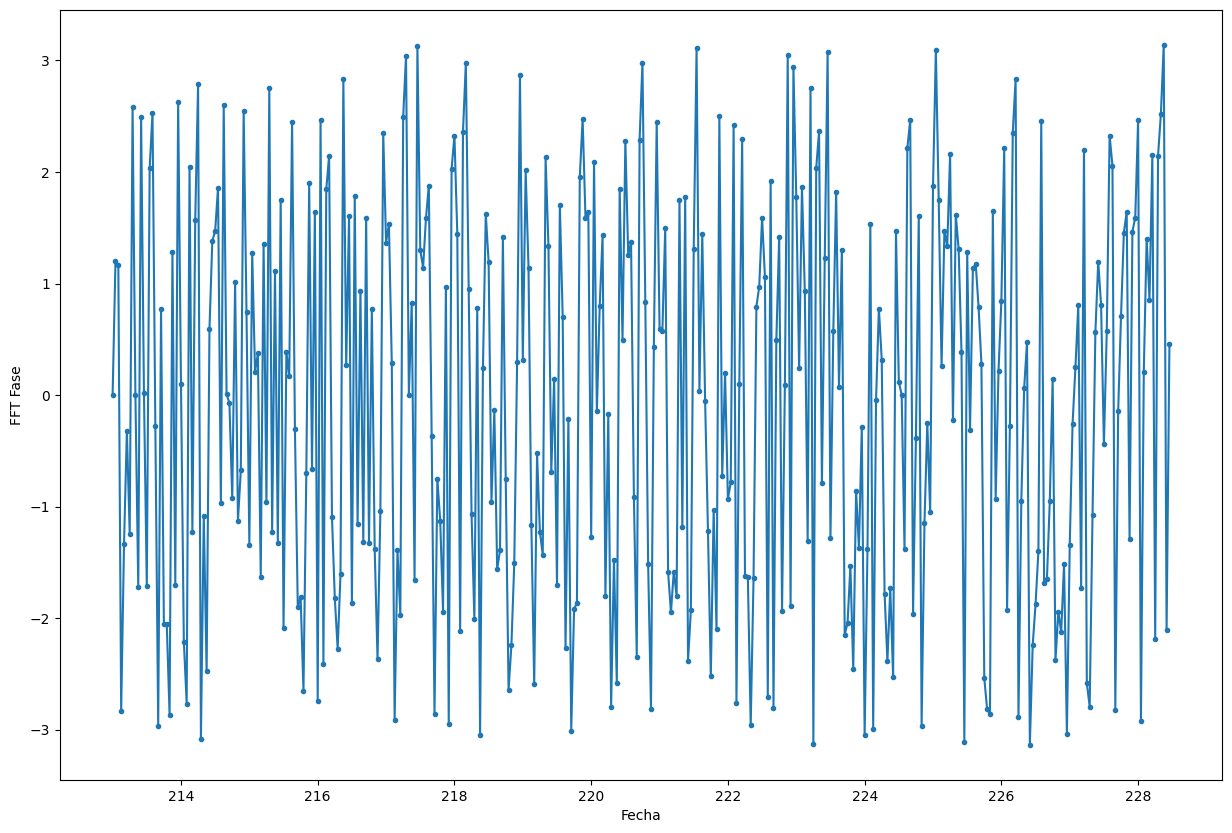

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(timegraf,tfourier_phase,'.-')
plt.xlabel('Fecha')
plt.ylabel('FFT Fase')

In [ ]:
# Calcular densidad espectral de potencia
psd = tfourier_mag ** 2

# Encontrar frecuencia dominante (excluyendo DC - componente 0)
idx_dominante = np.argmax(psd[1:]) + 1
freq_dominante = freqs[idx_dominante]
periodo_dominante = periodos[idx_dominante]

print("\n" + "="*70)
print("FRECUENCIA DOMINANTE:")
print("="*70)
print(f"Frecuencia: {freq_dominante:.6f} ciclos/hora")
print(f"Periodo: {periodo_dominante:.2f} horas ({periodo_dominante/24:.2f} días)")
print(f"Potencia: {psd[idx_dominante]:.2e}")

# Validación
if 23 <= periodo_dominante <= 25:
    print("Resultado: CORRECTO - Ciclo diario detectado (24h)")
else:
    print(f"ADVERTENCIA: Periodo dominante es {periodo_dominante:.2f}h, no 24h")
    print("Revisar datos o sensor")


FRECUENCIA DOMINANTE:
Frecuencia: 0.041611 ciclos/hora
Periodo: 24.03 horas (1.00 días)
Potencia: 9.90e+09
Resultado: CORRECTO - Ciclo diario detectado (24h)


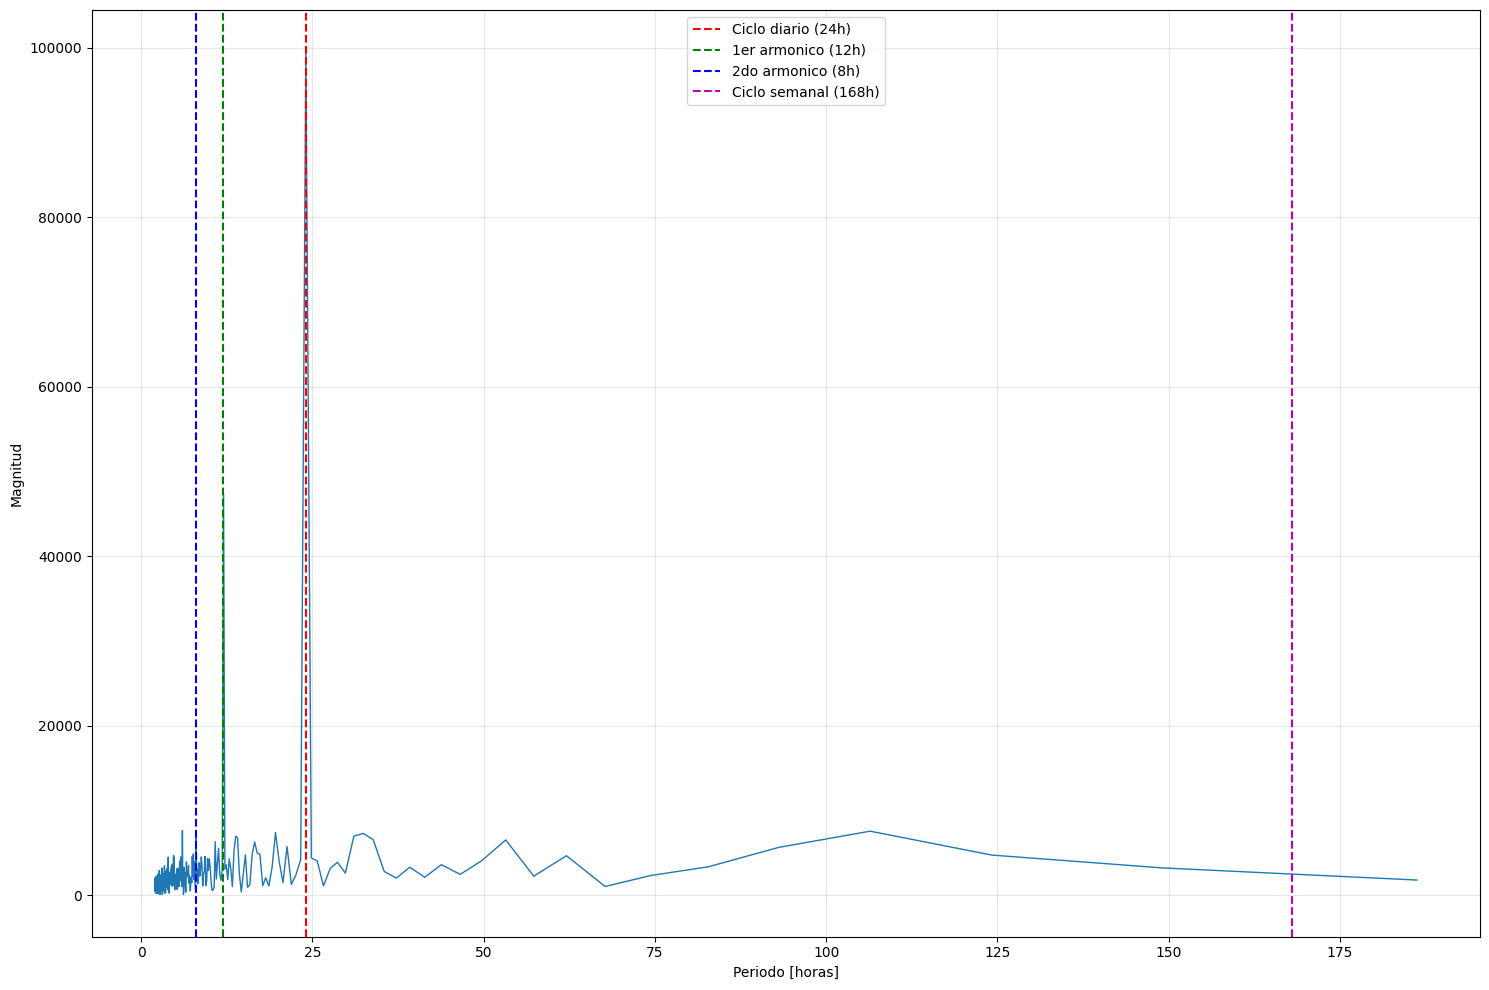

In [ ]:
periodos = np.zeros_like(freqs)
mask = freqs > 0
periodos[mask] = 1.0 / freqs[mask]

# Graficamos solo periodos entre 2 y 200 horas para ver ciclos relevantes
plt.figure(figsize=(15, 10))
mask_periodo = (periodos >= 2) & (periodos <= 200)
plt.plot(periodos[mask_periodo], tfourier_mag[mask_periodo], linewidth=1)
plt.xlabel('Periodo [horas]')
plt.ylabel('Magnitud')
#plt.title('Espectro de potencia en funcion del periodo')
plt.grid(True, alpha=0.3)

# Marcar periodos importantes
plt.axvline(x=24, color='r', linestyle='--', label='Ciclo diario (24h)')
plt.axvline(x=12, color='g', linestyle='--', label='1er armonico (12h)')
plt.axvline(x=8, color='b', linestyle='--', label='2do armonico (8h)')
plt.axvline(x=168, color='m', linestyle='--', label='Ciclo semanal (168h)')
"""
plt.axvline(x=periodo_dominante, color='black', linestyle='-', linewidth=2.5,
            label=f'Dominante: {periodo_dominante:.1f}h', alpha=0.8)
"""
plt.legend()

plt.tight_layout()
plt.show()


## Espectrograma

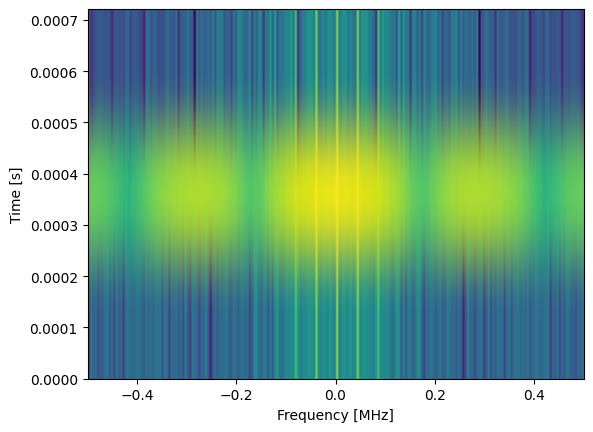

In [ ]:
num_rows = len(radiacion) // fft_size # // is an integer division which rounds down
spectrogram = np.zeros((num_rows, fft_size))
for i in range(num_rows):
    spectrogram[i,:] = 10*np.log10(np.abs(np.fft.fftshift(np.fft.fft(radiacion[i*fft_size:(i+1)*fft_size])))**2)

plt.imshow(spectrogram, aspect='auto', extent = [sample_rate/-2/1e6, sample_rate/2/1e6, 0, len(radiacion)/sample_rate])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Time [s]")
plt.show()

# Analisis de eficiencia

In [ ]:

# Parámetros del sistema
POTENCIA_PANEL = 565  # W
NUM_PANELES = 1260
POTENCIA_NOMINAL_kW = (POTENCIA_PANEL * NUM_PANELES) / 1000  # 712.9 kW
AREA_PANEL = 2.278  # m² (aproximado para este modelo)
AREA_TOTAL = AREA_PANEL * NUM_PANELES
EFICIENCIA_ESTIMADA = 0.218  # 21.8% eficiencia del panel
IRRADIANCIA_EXTRATERRESTRE = 1367  # W/m² (constante solar)
IRRADIANCIA_MAX_SUPERFICIE = 1200  # W/m² (máximo teórico en superficie)
IRRADIANCIA_TIPICA_MAX = 1000     # W/m² (STC - Standard Test Conditions)
